# BERT模型

NLP里的迁移学习
- 使用预训练好的模型来抽取词、句子的特征
    - 例如word2vec或语言模型
- 不更新预训练好的模型
- 需要构建新的网络来抓取新任务需要的信息
    - word2Vec忽略了时序信息，语言模型只看了一个方向

BERT的动机
- 基于微调的NLP模型
- 预训练的模型抽取了足够多的信息
- 新的任务只需要增加一个简单的输出层

BERT架构
- 只有编码器的Transformer
- 两个版本：
    - Base:#blocks= 12, hidden_size = 768, #heads= 12, #parameters= 110M
    - Large:#block2= 24, hidden_size = 1024, #heads= 16, #parameters= 340M
- 在大规模数据上进行训练>3B词

对输入的修改
- 每个样本是一个句子对
- 加入额外的片段嵌入
- 位置编码可以学习

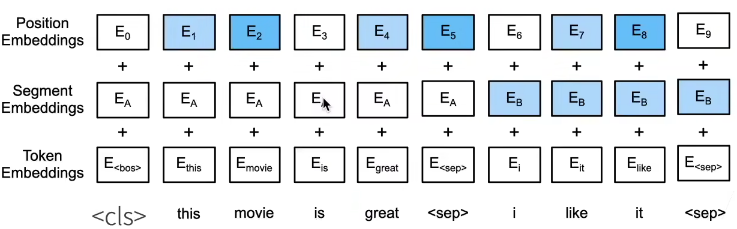

预训练任务1：带掩码的语言模型
- Transformer的编码器是双向，标准语言模型要求单向
- 带掩码的语言模型每次随机(15%概率)将一些词元换成<mask>
- 因为微调任务中不出现<mask>
    - 80%概率下，将选中的词元变成<mask>
    - 10%概率下换成一个随机词元
    - 10%概率下保持原有的词元

预训练任务2：下一个句子预测
- 预测一个句子对中两个句子是否相邻
- 训练样本中：
    - 50%概率选择相邻句子对：<cls>this movie is great <sep> i like it <sep>
    - 50%概率选择随机句子对：<cls>this movie is great <sep> hello world <sep>
- 将<cls>对应的输出放到一个全连接层来执行预测

总结
- BERT针对微调设计
- 基于Transformer的编码器做了如下修改
    - 模型更大，训练数据更多
    - 输入句子对，片段嵌入，可学习的位置编码
    - 训练时的两个任务：
        - 带掩码的语言模型
        - 下一个句子的预测

In [1]:
import torch, os, random
from torch import nn
from d2l import torch as d2l

d:\Anaconda\envs\d2l-zh\lib\site-packages\torch\_subclasses\functional_tensor.py:258: UserWarning: Failed to initialize NumPy: module compiled against API version 0xf but this version of numpy is 0xe (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_numpy.cpp:84.)
  cpu = _conversion_method_template(device=torch.device("cpu"))


In [2]:
#输入表示
#@save
def get_tokens_and_segments(tokens_a, tokens_b=None):
    """获取输入序列的词元及其片段索引"""
    tokens = ['<cls>'] + tokens_a + ['<sep>']
    # 0和1分别标记片段A和B
    segments = [0] * (len(tokens_a) + 2)
    if tokens_b is not None:
        tokens += tokens_b + ['<sep>']
        segments += [1] * (len(tokens_b) + 1)
    return tokens, segments

In [3]:
#实现BertEncoder类
#使用片段嵌入和可学习的位置嵌入
class BERTEncoder(nn.Module):
    """Bert编码器"""
    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, num_heads, num_layers, dropout,
                 max_len= 1000, key_size= 768, query_size= 768, value_size= 768,
                 **kwargs):
        super(BERTEncoder, self).__init__(**kwargs)
        self.token_embedding = nn.Embedding(vocab_size, num_hiddens)
        self.segment_embedding = nn.Embedding(2, num_hiddens)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(f"{i}", d2l.EncoderBlock(key_size, query_size, value_size,
                                                          num_hiddens, norm_shape, ffn_num_input, 
                                                          ffn_num_hiddens, num_heads, dropout, True))
        #将位置编码器设置为可学习的参数
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len, num_hiddens))

    def forward(self, tokens, segments, valid_lens):
        #X的形状保持不变:(batch_size, max_len, num_hiddens)
        X = self.token_embedding(tokens) + self.segment_embedding(segments)
        X = X + self.pos_embedding.data[:, :X.shape[1], :]
        for blk in self.blks:
            X = blk(X, valid_lens)
        return X

In [4]:
#演示BERTEncoder的前向推断
vocab_size, num_hiddens, ffn_num_hiddens, num_heads = 10000, 768, 1024, 4
norm_shape, ffn_num_input, num_layers, dropout = [768], 768, 2, 0.2
encoder = BERTEncoder(vocab_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, 
                      num_heads, num_layers, dropout)

In [5]:
tokens = torch.randint(0, vocab_size, (2, 8))
segments = torch.tensor([[0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 1, 1, 1, 1, 1]])
encoded_X = encoder(tokens, segments, None)
encoded_X.shape

torch.Size([2, 8, 768])

In [6]:
#预训练任务1：掩蔽语言模型(MLM)
class MaskLM(nn.Module):
    """BERT的掩蔽语言模型任务"""
    def __init__(self, vocab_size, num_hiddens, num_inputs= 768, **kwargs):
        super(MaskLM, self).__init__(**kwargs)
        self.mlp = nn.Sequential(nn.Linear(num_inputs, num_hiddens),
                                 nn.ReLU(),
                                 nn.LayerNorm(num_hiddens),
                                 nn.Linear(num_hiddens, vocab_size))
    
    def forward(self, X, pred_positions):
        num_pred_positions = pred_positions.shape[1]
        pred_positions = pred_positions.reshape(-1)
        batch_size = X.shape[0]
        batch_idx = torch.arange(0, batch_size)
        #假设batch_size= 2, num_pred_positions=3
        #那么batch_idx是np.array([0, 0, 0, 1, 1, 1])
        batch_idx = torch.repeat_interleave(batch_idx, num_pred_positions)
        masked_X = X[batch_idx, pred_positions]
        masked_X = masked_X.reshape((batch_size, num_pred_positions, -1))
        mlm_Y_hat = self.mlp(masked_X)
        return mlm_Y_hat

In [7]:
mlm = MaskLM(vocab_size, num_hiddens)
mlm_positions = torch.tensor([[1, 5, 2], [6, 1, 5]])
mlm_Y_hat = mlm(encoded_X, mlm_positions)
mlm_Y_hat.shape

torch.Size([2, 3, 10000])

In [8]:
mlm_Y = torch.tensor([[7, 8, 9], [10, 20, 30]])
loss = nn.CrossEntropyLoss(reduction= 'none')
mlm_l = loss(mlm_Y_hat.reshape((-1, vocab_size)), mlm_Y.reshape(-1))
mlm_l.shape

torch.Size([6])

In [9]:
#预训练任务2：执行下一句预测(Next Sentence Prediction)
class NextSentencePred(nn.Module):
    """BERT的下一句预测任务"""
    def __init__(self, num_inputs, **kwargs):
        super(NextSentencePred, self).__init__(**kwargs)
        self.output = nn.Linear(num_inputs, 2)
    
    def forward(self, X):
        #X的形状:(batch_size, num_hiddens)
        return self.output(X)

In [10]:
#NextSentencePred实例的前向推断返回每个BERT输入序列的二分类预测
encoded_X = torch.flatten(encoded_X, start_dim= 1)
#NSP的输入形状:(batch_size, num_hiddens)
nsp = NextSentencePred(encoded_X.shape[-1])
nsp_Y_hat = nsp(encoded_X)
nsp_Y_hat.shape

torch.Size([2, 2])

In [11]:
#还可以计算两个二元分类的交叉熵损失
nsp_y = torch.tensor([0, 1])
nsp_l = loss(nsp_Y_hat, nsp_y)
nsp_l.shape

torch.Size([2])

In [12]:
#整合代码
#@save
class BERTModel(nn.Module):
    """BERT模型"""
    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input, 
                 ffn_num_hiddens, num_heads, num_layers, dropout, 
                 max_len= 1000, key_size= 768, query_size= 768, value_size= 768, 
                 hid_in_features= 768, mlm_in_features= 768,
                 nsp_in_features= 768):
        super(BERTModel, self).__init__()
        self.encoder = BERTEncoder(vocab_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                                   num_heads, num_layers, dropout, max_len= max_len,
                                   key_size= key_size, query_size = query_size, 
                                   value_size= value_size)
        self.hidden = nn.Sequential(nn.Linear(hid_in_features, num_hiddens), nn.Tanh())
        self.mlm = MaskLM(vocab_size, num_hiddens, mlm_in_features)
        self.nsp = NextSentencePred(nsp_in_features)
    
    def forward(self, tokens, segments, valid_lens= None, pred_positions= None):
        encoded_X = self.encoder(tokens, segments, valid_lens)
        if pred_positions is not None:
            mlm_Y_hat = self.mlm(encoded_X, pred_positions)
        else:
            mlm_Y_hat = None
        #用于下一句预测的多层感知机分类器的隐藏层，0是“<cls>”标记的索引
        nsp_Y_hat = self.nsp(self.hidden(encoded_X[:, 0, :]))
        return encoded_X, mlm_Y_hat, nsp_Y_hat

In [13]:
#用于预训练BERT的数据集
# d2l.DATA_HUB['wikitext-2'] = ( 'https://s3.amazonaws.com/research.metamind.io/wikitext/'
#     'wikitext-2-v1.zip', '3c914d17d80b1459be871a5039ac23e752a53cbe')

def _read_wiki(data_dir):
    file_name = os.path.join(data_dir, 'wiki.train.tokens')
    with open(file_name, 'r', encoding= 'utf-8') as f:
        lines = f.readlines()
    #大写字母转换为小写字母
    paragraphs = [line.strip().lower().split(' . ') 
                  for line in lines if len(line.split(' . ')) >= 2]
    #随机打乱
    random.shuffle(paragraphs)
    return paragraphs

In [14]:
#为预训练任务定义辅助函数
#生成下一句预测任务的数据
def _get_next_sentence(sentence, next_sentence, paragraphs):
    if random.random() < 0.5:
        is_next = True
    else:
        #paragraphs是三重列表的嵌套结构
        next_sentence = random.choice(random.choice(paragraphs))
        is_next = False
    return sentence, next_sentence, is_next

In [15]:
#@save
def _get_nsp_data_from_paragraph(paragraph, paragraphs, vocab, max_len):
    _get_nsp_data_from_paragraph = []
    for i in range(len(paragraph) - 1):
        tokens_a, tokens_b, is_next = _get_next_sentence(paragraph[i], paragraph[i+1], paragraphs)
        #考虑1个'<cls>'词元和2个'<sep>'词元
        if len(tokens_a) + len(tokens_b) + 3 > max_len:
            continue
        tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
        _get_nsp_data_from_paragraph.append((tokens, segments, is_next))
    return _get_nsp_data_from_paragraph

In [16]:
#生成遮蔽语言模型任务的数据
def _replace_mlm_tokens(tokens, candidate_pred_positions, 
                        num_mlm_preds, vocab):
    mlm_input_tokens = [token for token in tokens]
    pred_positions_and_labels = []
    #打乱后用于在遮蔽语言模型任务中获取15%的随机词元进行预测
    random.shuffle(candidate_pred_positions)
    for mlm_pred_position in candidate_pred_positions:
        if len(pred_positions_and_labels) >= num_mlm_preds:
            break
        masked_token = None
        #80%的时间：将词替换为"<mask>"词元
        if random.random() < 0.8:
            masked_token = '<mask>'
        else:
            #10%的时间：保持不变
            if random.random() < 0.5:
                masked_token = tokens[mlm_pred_position]
            #10%的时间:用随机词替换该词
            else:
                masked_token = random.choice(vocab.idx_to_token)
        mlm_input_tokens[mlm_pred_position] = masked_token
        pred_positions_and_labels.append((mlm_pred_position, tokens[mlm_pred_position]))
    return mlm_input_tokens, pred_positions_and_labels

In [17]:
#将tokens作为输入，并返回输入词元的索引
def _get_mlm_data_from_tokens(tokens, vocab):
    candidate_pred_positions = []
    #tokens是一个字符串列表
    for i, token in enumerate(tokens):
        #在遮蔽语言模型任务中不会预测特殊词元
        if token in ['<cls>', '<sep>']:
            continue
        candidate_pred_positions.append(i)
    #遮蔽语言模型任务中预测15%的随机词元
    num_mlm_preds = max(1, round(len(tokens) * 0.15))
    mlm_input_tokens, pred_positions_and_labels = _replace_mlm_tokens(tokens, candidate_pred_positions, 
                                                                      num_mlm_preds, vocab)
    pred_positions_and_labels = sorted(pred_positions_and_labels, key= lambda x: x[0])
    pred_positions = [v[0] for v in pred_positions_and_labels]
    mlm_pred_labels = [v[1] for v in pred_positions_and_labels]
    return vocab[mlm_input_tokens], pred_positions, vocab[mlm_pred_labels]

In [18]:
#将文本转换为预训练数据集
def _pad_bert_inputs(examples, max_len, vocab):
    max_num_mlm_preds = round(max_len * 0.15)
    all_token_ids, all_segments, valid_lens, = [], [], []
    all_pred_positions, all_mlm_weights, all_mlm_labels = [], [], []
    nsp_labels = []
    for (token_ids, pred_positions, mlm_pred_label_ids, 
         segments, is_next) in examples:
        all_token_ids.append(torch.tensor(token_ids + [vocab['<pad>']] *(
            max_len - len(token_ids)), dtype= torch.long))
        all_segments.append(torch.tensor(segments + [0] *(
            max_len- len(segments)), dtype= torch.long))
        valid_lens.append(torch.tensor(len(token_ids), dtype= torch.float32))
        all_pred_positions.append(torch.tensor(pred_positions + [0] *(max_num_mlm_preds- len(pred_positions)), 
                                               dtype= torch.long))
        #填充词元的预测将通过乘以0的权重在损失中过滤
        all_mlm_weights.append(torch.tensor([1.0] * len(mlm_pred_label_ids) + [0.0] * (max_num_mlm_preds - len(pred_positions)), 
                                            dtype= torch.float32))
        all_mlm_labels.append(torch.tensor(mlm_pred_label_ids + [0] *(max_num_mlm_preds - len(mlm_pred_label_ids)), 
                                           dtype= torch.long))
        nsp_labels.append(torch.tensor(is_next, dtype= torch.long))
    return (all_token_ids, all_segments, valid_lens, all_pred_positions, 
            all_mlm_weights, all_mlm_labels, nsp_labels)

In [19]:
#定义_WikiTextDataset类为用于预训练BERT的WikiText-2数据集
class _WikiTextDataset(torch.utils.data.Dataset):
    def __init__(self, paragraphs, max_len):
        #输入paragraphs[i]是代表段落的句子字符串列表
        #而输出paragraphs[i]是代表段落的句子列表，其中每个句子都是词元列表
        paragraphs = [d2l.tokenize(paragraph, token= 'word')for paragraph in paragraphs]
        sentences = [sentence for paragraph in paragraphs for sentence in paragraph]
        self.vocab = d2l.Vocab(sentences, min_freq= 5, reserved_tokens= [
            '<pad>', '<mask>', '<cls>', '<sep>'])
        #获取下一句子预测任务的数据
        examples = []
        for paragraph in paragraphs:
            examples.extend(_get_nsp_data_from_paragraph(paragraph, paragraphs, self.vocab, max_len))
        examples = [(_get_mlm_data_from_tokens(tokens, self.vocab) + (segments, is_next)) 
                    for tokens, segments, is_next in examples]
        #填充输入
        (self.all_token_ids, self.all_segments, self.valid_lens, 
         self.all_pred_positions, self.all_mlm_weights, 
         self.all_mlm_labels, self.nsp_labels) = _pad_bert_inputs(examples, max_len, self.vocab)
    
    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx], 
                self.valid_lens[idx], self.all_pred_positions[idx], self.all_mlm_weights[idx],
                self.all_mlm_labels[idx], self.nsp_labels[idx])
    
    def __len__(self):
        return len(self.all_token_ids)

In [20]:
#@save
def load_data_wiki(batch_size, max_len):
    """加载WikiText-2数据集"""
    data_dir = "D:\code_projects\data\dataset_d2l-main\wikitext-2-v1\wikitext-2"
    paragraphs = _read_wiki(data_dir)
    train_set = _WikiTextDataset(paragraphs, max_len)
    train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle= True)

    return train_iter, train_set.vocab

In [21]:
#将批量大小设置为512，将BERT输入序列的最大长度设置为64，打印出小批量的BERT预训练样本的形状
batch_size, max_len = 512, 64
train_iter, vocab = load_data_wiki(batch_size, max_len)

for (tokens_X, segments_X, valid_lens_X, pred_positions_X, mlm_weights_X, 
     mlm_Y, nsp_Y) in train_iter:
    print(tokens_X.shape, segments_X.shape, valid_lens_X.shape, 
          pred_positions_X.shape, mlm_weights_X.shape, mlm_Y.shape, nsp_Y.shape)
    break

torch.Size([512, 64]) torch.Size([512, 64]) torch.Size([512]) torch.Size([512, 10]) torch.Size([512, 10]) torch.Size([512, 10]) torch.Size([512])


In [22]:
len(vocab)

20256

In [23]:
batch_size, max_len = 512, 64
train_iter, vocab = load_data_wiki(batch_size, max_len)

In [24]:
net = d2l.BERTModel(len(vocab), num_hiddens= 128, norm_shape= [128], 
                    ffn_num_input= 128, ffn_num_hiddens= 256, num_heads= 2,
                    num_layers= 2, dropout= 0.2, key_size= 128, query_size= 128,
                    value_size= 128, hid_in_features= 128,  mlm_in_features= 128,
                    nsp_in_features= 128)
devices = d2l.try_all_gpus()
loss = nn.CrossEntropyLoss()

In [25]:
#@save
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X, segments_X,
                         valid_lens_x, pred_positions_X, mlm_weights_X,
                         mlm_Y, nsp_y):
    #前向传播
    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X, valid_lens_x.reshape(-1), pred_positions_X)
    #计算遮蔽语言模型损失
    mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) * mlm_weights_X.reshape(-1, 1)
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)
    #计算下一个预测句子任务的损失
    nsp_l = loss(nsp_Y_hat, nsp_y)
    l = mlm_l + nsp_l
    return mlm_l, nsp_l, l

In [26]:
#在wikitext-2数据集上预训练BERT模型
def train_bert(train_iter, net, loss, vocab_size, devices, num_steps):
    net = nn.DataParallel(net, device_ids= devices).to(devices[0])
    trainer = torch.optim.Adam(net.parameters(), lr = 1e-2)
    step, timer = 0, d2l.Timer()
    animator = d2l.Animator(xlabel= 'step', ylabel= 'loss', \
                            xlim= [1, num_steps], legend= ['mlm', 'nsp'])
    #遮蔽语言模型损失的和，下一句预测任务损失的和，句子的数量，计数
    metric = d2l.Accumulator(4)
    num_steps_reached = False
    while step < num_steps and not num_steps_reached:
        for tokens_X, segments_X, valid_lens_x, pred_positions_X, \
        mlm_weights_X, mlm_Y, nsp_y in train_iter:
            tokens_X = tokens_X.to(devices[0])
            segments_X = segments_X.to(devices[0])
            valid_lens_x = valid_lens_x.to(devices[0])
            pred_positions_X = pred_positions_X.to(devices[0])
            mlm_weights_X = mlm_weights_X.to(devices[0])
            mlm_Y, nsp_y = mlm_Y.to(devices[0]), nsp_y.to(devices[0])
            trainer.zero_grad()
            timer.start()
            mlm_l, nsp_l, l = _get_batch_loss_bert(net, loss, vocab_size, tokens_X, segments_X,
                                                   valid_lens_x, pred_positions_X, 
                                                   mlm_weights_X, mlm_Y, nsp_y)
            l.backward()
            trainer.step()
            metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
            timer.stop()
            animator.add(step + 1, (metric[0] / metric[3], metric[1] / metric[3]))
            step += 1
            if step == num_steps:
                num_steps_reached = True
                break
    
    print(f'MLM loss {metric[0] / metric[3]:.3f},' 
          f'NSP loss {metric[1] / metric[3]:.3f}')
    print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on '
          f'{str(devices)}')

MLM loss 5.407,NSP loss 0.756
3862.7 sentence pairs/sec on [device(type='cuda', index=0)]


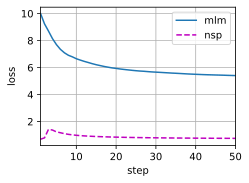

In [27]:
train_bert(train_iter, net, loss, len(vocab), devices, 50)

In [28]:
#用BERT表示文本
def get_bert_encoding(net, tokens_a, tokens_b= None):
    tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
    token_ids = torch.tensor(vocab[tokens], device= devices[0]).unsqueeze(0)
    segments = torch.tensor(segments, device= devices[0]).unsqueeze(0)
    valid_len = torch.tensor(len(tokens), device= devices[0]).unsqueeze(0)
    encoded_X, _, _ = net(token_ids, segments, valid_len)
    return encoded_X

In [29]:
tokens_a = ['a', 'crane', 'is', 'flying']
encoded_text = get_bert_encoding(net, tokens_a)
#拆分的词元:'<cls>', 'a', 'crane', 'is', 'flying', '<sep>'
encoded_text_cls = encoded_text[:, 0, :]
encoded_text_crane = encoded_text[:, 2, :]
encoded_text.shape, encoded_text_cls.shape, encoded_text_crane[0][:3]

(torch.Size([1, 6, 128]),
 torch.Size([1, 128]),
 tensor([ 0.5007,  0.5050, -0.3099], device='cuda:0', grad_fn=<SliceBackward0>))

In [30]:
tokens_a, tokens_b = ['a', 'crane', 'is', 'flying'], ['he', 'just', 'left']
encoded_pair = get_bert_encoding(net, tokens_a, tokens_b)
#词元：'<cls>', 'a', 'crane', 'is', 'flying', '<sep>', 'he', 
#'just', 'left', '<sep>'
encoded_pair_cls = encoded_pair[:, 0, :]
encoded_pair_crane = encoded_pair[:, 2, :]
encoded_pair.shape, encoded_pair_cls.shape, encoded_pair_crane[0][:3]

(torch.Size([1, 10, 128]),
 torch.Size([1, 128]),
 tensor([-0.0957,  0.0044,  0.5890], device='cuda:0', grad_fn=<SliceBackward0>))

微调BERT
- BERT对每一个词元返回抽取了上下文信息的特征向量
- 不同任务使用不同的特性

句子分类
- 将< cls >对应的向量输入到全连接层分类

命名实体识别
- 识别一个词元是不是命名实体，例如人名、机构以及位置
- 将非特殊词元放进全连接层分类

问题回答
- 给定一个问题和描述文字，找出一个片段作为回答
- 对片段中的每个词元预测它是不是回答的开头或结束

总结
- 即使下游任务各有不同，使用BERT微调时均只需要增加输出层(Dense层)
- 根据任务的不同，输入的表示，和使用的BERT特征也会不一样

In [31]:
import json, multiprocessing, os, torch
from torch import nn
from d2l import torch as d2l

In [32]:
#下载预训练的BERT模型文件
d2l.DATA_HUB['bert.base'] = (d2l.DATA_URL + 'bert.base.torch.zip',
                             '225d66f04cae318b841a13d32af3acc165f253ac')
d2l.DATA_HUB['bert.small'] = (d2l.DATA_URL + 'bert.small.torch.zip',
                              'c72329e68a732bef0452e4b96a1c341c8910f81f')

In [33]:
#使用函数读取模型文件中的模型参数
def load_pretrained_model(pretrained_model, num_hiddens, ffn_num_hiddens,
                          num_heads, num_layers, dropout, max_len, devices):
    data_dir = d2l.download_extract(pretrained_model)
    #定义空词列表以加载预定义词表
    vocab = d2l.Vocab()
    vocab.idx_to_token = json.load(open(os.path.join(data_dir, 'vocab.json')))
    vocab.token_to_idx = {token: idx for idx, token in enumerate(vocab.idx_to_token)}
    bert = d2l.BERTModel(len(vocab), num_hiddens, norm_shape= [256], 
                         ffn_num_input= 256, ffn_num_hiddens= ffn_num_hiddens, num_heads= 4, 
                         num_layers= 2, dropout= 0.2, max_len = max_len, key_size= 256, query_size= 256,
                         value_size= 256, hid_in_features= 256, 
                         mlm_in_features= 256, nsp_in_features= 256)
    #加载预训练后的BERT模型参数
    bert.load_state_dict(torch.load(os.path.join(data_dir, 
                                                 'pretrained.params')))
    return bert, vocab

In [34]:
devices = d2l.try_all_gpus()
bert, vocab = load_pretrained_model('bert.small', num_hiddens= 256, ffn_num_hiddens= 512, 
                                    num_heads= 4, num_layers= 2, dropout= 0.1, max_len= 512, 
                                    devices= devices)

C:\Users\user\AppData\Local\Temp\ipykernel_4208\413568249.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bert.load_state_dict(torch.load(os.path.join(data_dir,


In [40]:
#微调BERT的数据集
class SNLIBERTDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len, vocab= None):
        all_premise_hypothesis_tokens = [[p_tokens, h_tokens] for p_tokens, h_tokens
                                         in zip(*[d2l.tokenize([s.lower() for s in sentences])
                                                  for sentences in dataset[:2]])]
        self.labels = torch.tensor(dataset[2])
        self.vocab = vocab
        self.max_len = max_len
        (self.all_token_ids, self.all_segments, 
         self.valid_lens) = self._preprocess(all_premise_hypothesis_tokens)
        print('read' + str(len(self.all_token_ids)) + 'examples')
    
    def _preprocess(self, all_premise_hypothesis_tokens):
        #使用多线程进行文本预处理
        pool = multiprocessing.Pool(4)
        out = pool.map(self._mp_worker, all_premise_hypothesis_tokens)
        all_token_ids = [token_ids for token_ids, segments, valid_len in out]
        all_segments = [segments for token_ids, segments, valid_len in out]
        valid_lens = [valid_len for token_ids, segments, valid_len in out]
        return (torch.tensor(all_token_ids, dtype= torch.long),
                torch.tensor(all_segments, dtype= torch.long),
                torch.tensor(valid_lens))
    
    def _mp_worker(self, premise_hypothesis_tokens):
        p_tokens, h_tokens = premise_hypothesis_tokens
        self._truncate_pair_of_tokens(p_tokens, h_tokens)
        tokens, segments = d2l.get_tokens_and_segments(p_tokens, h_tokens)
        token_ids = self.vocab[tokens] + [self.vocab['<pad>']] \
                    * (self.max_len - len(tokens))
        segments = segments + [0] * (self.max_len - len(segments))
        valid_len = len(tokens)
        return token_ids, segments, valid_len
    
    def _truncate_pair_of_tokens(self, p_tokens, h_tokens):
        #为BERT输入中的'<cls>'、'<sep>'、'<sep>'词元保留位置
        while len(p_tokens) + len(h_tokens) > self.max_len - 3:
            if len(p_tokens) > len(h_tokens):
                p_tokens.pop()
            else:
                h_tokens.pop()
    
    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx]), self.labels[idx]
    
    def __len__(self):
        return len(self.all_token_ids)

In [ ]:
batch_size, max_len, num_workers = 512, 128, d2l.get_dataloader_workers()
data_dir = 'D:\code_projects\data\snli_1.0'
train_set = SNLIBERTDataset(d2l.read_snli(data_dir, True), max_len, vocab)
test_set = SNLIBERTDataset(d2l.read_snli(data_dir, False), max_len, vocab)
train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle= True,
                                         num_workers= num_workers)
test_iter = torch.utils.data.DataLoader(test_set, batch_size, shuffle= False, 
                                        num_workers= num_workers)

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self, bert):
        super(BERTClassifier, self).__init__()
        self.encoder = bert.encoder
        self.hidden = bert.hidden
        #输出层
        self.output = nn.Linear(256, 3)

    def forward(self, inputs):
        tokens_X, segments_X, valid_lens_x = inputs
        encoded_X = self.encoder(tokens_X, segments_X, valid_lens_x)
        return self.output(self.hidden(encoded_X[:, 0, :]))

In [ ]:
net = BERTClassifier(bert)
lr, num_epochs = 1e-4, 5
trainer = torch.optim.Adam(net.parameters(), lr)
loss = nn.CrossEntropyLoss(reduction= 'none')
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, 
               devices)